<a href="https://colab.research.google.com/github/Anisafi/T3-deeplearning/blob/main/coba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np, time
from google.colab import drive

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load dataset
tfm = T.Compose([T.Resize((224,224)), T.ToTensor()])
path = '/content/drive/MyDrive/dataset_anisa'
data = ImageFolder(path, transform=tfm)
classes = data.classes


In [3]:
# Split
n = len(data)
train_len, val_len = int(0.7*n), int(0.15*n)
test_len = n - train_len - val_len
train_ds, val_ds, test_ds = random_split(data, [train_len, val_len, test_len])
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)


In [4]:
# Model CNN Ringkas
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*28*28, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x): return self.net(x)

model = SimpleCNN(num_classes=len(classes)).to(device)

# Loss & Optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)


In [5]:
# Train loop
for epoch in range(50):
    model.train()
    start = time.time()
    total_loss, correct, count = 0, 0, 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == yb).sum().item()
        count += len(yb)
    train_acc = correct / count
    train_loss = total_loss / len(train_dl)

    # Validation
    model.eval()
    val_loss, val_correct, val_count = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item()
            val_correct += (pred.argmax(1) == yb).sum().item()
            val_count += len(yb)
    val_acc = val_correct / val_count
    val_loss /= len(val_dl)

    elapsed = time.time() - start
    print(f"Epoch {epoch+1}/50\n{len(train_dl)}/{len(train_dl)} ━━━━━━━━━━━━━━━━━━━━ "
          f"{int(elapsed)}s {int(elapsed/len(train_dl))}s/step - "
          f"accuracy: {train_acc:.4f} - loss: {train_loss:.4f} - "
          f"val_accuracy: {val_acc:.4f} - val_loss: {val_loss:.4f}")


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 431s 15s/step - accuracy: 0.3964 - loss: 1.3638 - val_accuracy: 0.4111 - val_loss: 1.3150
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - accuracy: 0.5060 - loss: 1.1764 - val_accuracy: 0.5111 - val_loss: 1.1364
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 230s 8s/step - accuracy: 0.5571 - loss: 0.9733 - val_accuracy: 0.4222 - val_loss: 1.0189
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 233s 8s/step - accuracy: 0.6857 - loss: 0.8835 - val_accuracy: 0.6278 - val_loss: 0.9679
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 220s 8s/step - accuracy: 0.7083 - loss: 0.8081 - val_accuracy: 0.7444 - val_loss: 0.8562
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 222s 8s/step - accuracy: 0.7357 - loss: 0.7339 - val_accuracy: 0.6722 - val_loss: 0.8225
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 238s 8s/step - accuracy: 0.7405 - loss: 0.6798 - val_accuracy: 0.7667 - val_loss: 0.7480
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 228s 8s/step - accuracy: 0.7738 - loss: 0.6105 - val_accuracy: 0.7889 - 

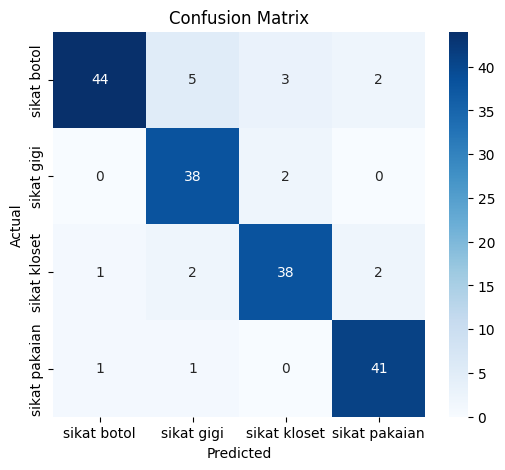

               precision    recall  f1-score   support

  sikat botol       0.96      0.81      0.88        54
   sikat gigi       0.83      0.95      0.88        40
 sikat kloset       0.88      0.88      0.88        43
sikat pakaian       0.91      0.95      0.93        43

     accuracy                           0.89       180
    macro avg       0.89      0.90      0.89       180
 weighted avg       0.90      0.89      0.89       180



In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluasi pada test set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        y_pred.extend(preds.numpy())
        y_true.extend(yb.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=classes))
